# Alan's Benchmarking Report Pages

In [1]:
import pickle
import pandas as pd
import numpy as np
from importlib import reload
import sys

# bench_util module is in the parent directory, because it will be part of
# the production code.  Add the parent directory to the Path so Python can
# import from there
sys.path.insert(0, '../')   
import bench_util as bu
import graph_util as gu

## Unpickle the Dataframe for Preprocessed Utility Data & Make Utility Function Object

In [2]:
# Unpickle the pre-processed DataFrame
df = pickle.load(open('dfu3.pkl', 'rb'))

# Unpickle the raw utility bill DataFrame, which is needed below to make
# the utility function object.
df_raw = pickle.load(open('df_raw.pkl', 'rb'))

df.head()  # the processed data

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
0,03,Electricity,2010,7,Electricity charge,-,24.137931,35.0,0.000000,2011,1,0.000000
1,03,Electricity,2010,7,Electricity charge,kWh,1304.274655,9.5,6656.551724,2011,1,22.712154
2,03,Electricity,2010,8,Electricity charge,-,39.498433,62.0,0.000000,2011,2,0.000000
3,03,Electricity,2010,8,Electricity charge,kWh,4940.646254,31.0,26822.236155,2011,2,91.517470
4,03,Electricity,2010,9,Electricity charge,-,16.363636,27.0,0.000000,2011,3,0.000000


In [3]:
# this is only needed to update any code changes I may have made
# since last importing the module above.
reload(bu)  
reload(gu)

# Make an object that has the various utility functions.
# The object needs access to the raw utility bill DataFrame and the spreadsheet
# containing other application data.
ut = bu.Util(df_raw, '../data/Other_Building_Data.xlsx')

## Set Site ID for All of the Reports Below

In [4]:
site = 'ANSBG1'

## DataFrame for "Energy Index Comparison" Report, Page 2

In [5]:
# Need to have this constant at the top of the script in order to know what
# Fiscal Year to use in the Report.
FISCAL_YEAR_FOR_ONE_YEAR_REPORT = 2016

### Table 1

### Table 2

In [6]:
# Filter down to just the records of the targeted fiscal year
df1 = df.query('fiscal_year == @FISCAL_YEAR_FOR_ONE_YEAR_REPORT')
df1.head()

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
78,03,Electricity,2015,7,Electricity charge,-,39.091459,62.0,0.000000,2016,1,0.000000
79,03,Electricity,2015,7,Electricity charge,kWh,3603.339259,31.0,16614.193548,2016,1,56.687628
80,03,Electricity,2015,8,Electricity charge,-,15.679374,25.0,0.000000,2016,2,0.000000
81,03,Electricity,2015,8,Electricity charge,kWh,4567.802303,68.0,23701.950202,2016,2,80.871054
82,03,Electricity,2015,9,Electricity charge,kWh,5757.846701,90.0,31256.845683,2016,3,106.648357


In [7]:
# Get Total Utility cost by building. This includes non-energy utilities as well.
df2 = df1.pivot_table(index='site_id', values=['cost'], aggfunc=np.sum)
df2.columns = ['cost_total']
df2.head()

,cost_total
site_id,
03,110978.515317
04,117368.777340
05,536715.062940
06,111150.278132
07,114241.225387


In [8]:
# Save this into the Final DataFrame that we will build up as we go.
df_final = df2.copy()

In [9]:
# Get a list of the Energy Services and restrict the data to
# just these services
energy_svcs = bu.missing_energy_services([])
df2 = df1.query('service_type == @energy_svcs')
df2.service_type.unique()

array(['Electricity', 'Natural Gas', 'Oil #1', 'Steam'], dtype=object)

In [10]:
# Summarize Cost by Service Type
df3 = pd.pivot_table(df2, index='site_id', columns='service_type', values='cost', aggfunc=np.sum)
df3.head()

service_type,Electricity,Natural Gas,Oil #1,Steam
site_id,,,,
03,72445.857903,2694.708115,25462.23,NaN
04,73894.233046,1810.998276,27422.11,NaN
05,329872.481124,NaN,NaN,152059.040143
06,66238.678564,1649.382308,24443.21,NaN
07,77881.893809,5273.385696,12884.15,NaN


In [11]:
# Change column names
cols = ['cost_{}'.format(bu.change_name(col)) for col in df3.columns]
df3.columns = cols
df3.head()

,cost_electricity,cost_natural_gas,cost_fuel_oil,cost_district_heat
site_id,,,,
03,72445.857903,2694.708115,25462.23,NaN
04,73894.233046,1810.998276,27422.11,NaN
05,329872.481124,NaN,NaN,152059.040143
06,66238.678564,1649.382308,24443.21,NaN
07,77881.893809,5273.385696,12884.15,NaN


In [12]:
# Add a total energy cost column
df3['cost_total_energy'] = df3.sum(axis=1)
df3.head()

,cost_electricity,cost_natural_gas,cost_fuel_oil,cost_district_heat,cost_total_energy
site_id,,,,,
03,72445.857903,2694.708115,25462.23,NaN,100602.796018
04,73894.233046,1810.998276,27422.11,NaN,103127.341322
05,329872.481124,NaN,NaN,152059.040143,481931.521267
06,66238.678564,1649.382308,24443.21,NaN,92331.270872
07,77881.893809,5273.385696,12884.15,NaN,96039.429504


In [13]:
# Add a total Heat Cost Column
df3['cost_total_heat'] = df3.cost_total_energy.fillna(0.0) - df3.cost_electricity.fillna(0.0)
df3.head()

,cost_electricity,cost_natural_gas,cost_fuel_oil,cost_district_heat,cost_total_energy,cost_total_heat
site_id,,,,,,
03,72445.857903,2694.708115,25462.23,NaN,100602.796018,28156.938115
04,73894.233046,1810.998276,27422.11,NaN,103127.341322,29233.108276
05,329872.481124,NaN,NaN,152059.040143,481931.521267,152059.040143
06,66238.678564,1649.382308,24443.21,NaN,92331.270872,26092.592308
07,77881.893809,5273.385696,12884.15,NaN,96039.429504,18157.535696


In [14]:
# Add this to the final DataFrame
df_final = pd.concat([df_final, df3], axis=1)
df_final.head()

,cost_total,cost_electricity,cost_natural_gas,cost_fuel_oil,cost_district_heat,cost_total_energy,cost_total_heat
03,110978.515317,72445.857903,2694.708115,25462.23,NaN,100602.796018,28156.938115
04,117368.777340,73894.233046,1810.998276,27422.11,NaN,103127.341322,29233.108276
05,536715.062940,329872.481124,NaN,NaN,152059.040143,481931.521267,152059.040143
06,111150.278132,66238.678564,1649.382308,24443.21,NaN,92331.270872,26092.592308
07,114241.225387,77881.893809,5273.385696,12884.15,NaN,96039.429504,18157.535696


In [15]:
# Summarize MMBtu by Service Type
df3 = pd.pivot_table(df2, index='site_id', columns='service_type', values='mmbtu', aggfunc=np.sum)
df3.head()

service_type,Electricity,Natural Gas,Oil #1,Steam
site_id,,,,
03,1262.055985,100.094903,2455.920,NaN
04,1364.923930,55.896000,2122.605,NaN
05,6072.938690,NaN,NaN,10792.771429
06,1213.149257,47.834710,1914.705,NaN
07,1408.801323,229.159452,1021.815,NaN


In [16]:
# Change column names
cols = ['mmbtu_{}'.format(bu.change_name(col)) for col in df3.columns]
df3.columns = cols
df3.head()

,mmbtu_electricity,mmbtu_natural_gas,mmbtu_fuel_oil,mmbtu_district_heat
site_id,,,,
03,1262.055985,100.094903,2455.920,NaN
04,1364.923930,55.896000,2122.605,NaN
05,6072.938690,NaN,NaN,10792.771429
06,1213.149257,47.834710,1914.705,NaN
07,1408.801323,229.159452,1021.815,NaN


In [17]:
# Add a total mmbtu column
df3['mmbtu_total'] = df3.sum(axis=1)
df3.head()

,mmbtu_electricity,mmbtu_natural_gas,mmbtu_fuel_oil,mmbtu_district_heat,mmbtu_total
site_id,,,,,
03,1262.055985,100.094903,2455.920,NaN,3818.070888
04,1364.923930,55.896000,2122.605,NaN,3543.424930
05,6072.938690,NaN,NaN,10792.771429,16865.710119
06,1213.149257,47.834710,1914.705,NaN,3175.688967
07,1408.801323,229.159452,1021.815,NaN,2659.775775


In [18]:
# Add a total Heat mmbtu Column
df3['mmbtu_total_heat'] = df3.mmbtu_total.fillna(0.0) - df3.mmbtu_electricity.fillna(0.0)
df3.head()

,mmbtu_electricity,mmbtu_natural_gas,mmbtu_fuel_oil,mmbtu_district_heat,mmbtu_total,mmbtu_total_heat
site_id,,,,,,
03,1262.055985,100.094903,2455.920,NaN,3818.070888,2556.014903
04,1364.923930,55.896000,2122.605,NaN,3543.424930,2178.501000
05,6072.938690,NaN,NaN,10792.771429,16865.710119,10792.771429
06,1213.149257,47.834710,1914.705,NaN,3175.688967,1962.539710
07,1408.801323,229.159452,1021.815,NaN,2659.775775,1250.974452


In [19]:
# Add this to the final DataFrame
df_final = pd.concat([df_final, df3], axis=1)
df_final.head()

,cost_total,cost_electricity,cost_natural_gas,cost_fuel_oil,cost_district_heat,cost_total_energy,cost_total_heat,mmbtu_electricity,mmbtu_natural_gas,mmbtu_fuel_oil,mmbtu_district_heat,mmbtu_total,mmbtu_total_heat
03,110978.515317,72445.857903,2694.708115,25462.23,NaN,100602.796018,28156.938115,1262.055985,100.094903,2455.920,NaN,3818.070888,2556.014903
04,117368.777340,73894.233046,1810.998276,27422.11,NaN,103127.341322,29233.108276,1364.923930,55.896000,2122.605,NaN,3543.424930,2178.501000
05,536715.062940,329872.481124,NaN,NaN,152059.040143,481931.521267,152059.040143,6072.938690,NaN,NaN,10792.771429,16865.710119,10792.771429
06,111150.278132,66238.678564,1649.382308,24443.21,NaN,92331.270872,26092.592308,1213.149257,47.834710,1914.705,NaN,3175.688967,1962.539710
07,114241.225387,77881.893809,5273.385696,12884.15,NaN,96039.429504,18157.535696,1408.801323,229.159452,1021.815,NaN,2659.775775,1250.974452


In [20]:
# Electricity kWh summed by building
df3 = pd.pivot_table(df2.query('units == "kWh"'), index='site_id', values='usage', aggfunc=np.sum)
df3.columns = ['electricity_kWh']
df3.head()

,electricity_kWh
site_id,
03,3.698875e+05
04,4.000363e+05
05,1.779877e+06
06,3.555537e+05
07,4.128961e+05


In [21]:
# Include in Final DF
df_final = pd.concat([df_final, df3], axis=1)
df_final.head()

,cost_total,cost_electricity,cost_natural_gas,cost_fuel_oil,cost_district_heat,cost_total_energy,cost_total_heat,mmbtu_electricity,mmbtu_natural_gas,mmbtu_fuel_oil,mmbtu_district_heat,mmbtu_total,mmbtu_total_heat,electricity_kWh
03,110978.515317,72445.857903,2694.708115,25462.23,NaN,100602.796018,28156.938115,1262.055985,100.094903,2455.920,NaN,3818.070888,2556.014903,3.698875e+05
04,117368.777340,73894.233046,1810.998276,27422.11,NaN,103127.341322,29233.108276,1364.923930,55.896000,2122.605,NaN,3543.424930,2178.501000,4.000363e+05
05,536715.062940,329872.481124,NaN,NaN,152059.040143,481931.521267,152059.040143,6072.938690,NaN,NaN,10792.771429,16865.710119,10792.771429,1.779877e+06
06,111150.278132,66238.678564,1649.382308,24443.21,NaN,92331.270872,26092.592308,1213.149257,47.834710,1914.705,NaN,3175.688967,1962.539710,3.555537e+05
07,114241.225387,77881.893809,5273.385696,12884.15,NaN,96039.429504,18157.535696,1408.801323,229.159452,1021.815,NaN,2659.775775,1250.974452,4.128961e+05


In [22]:
# Electricity kW, both Average and Max by building
df3 = pd.pivot_table(df2.query('units == "kW"'), index='site_id', values='usage', aggfunc=[np.mean, np.max])
df3.columns = ['kW_average', 'kW_max']
df3.head()

,kW_average,kW_max
site_id,,
ASLELC1,116.112001,141.213739
ASLELC2,136.252236,176.485000
BALHHW,78.165155,101.244118
BAOBG1,185.840038,206.610091
BHPSKI2,46.528571,59.254372


In [23]:
# Add into Final Frame
df_final = pd.concat([df_final, df3], axis=1)
df_final.head()

,cost_total,cost_electricity,cost_natural_gas,cost_fuel_oil,cost_district_heat,cost_total_energy,cost_total_heat,mmbtu_electricity,mmbtu_natural_gas,mmbtu_fuel_oil,mmbtu_district_heat,mmbtu_total,mmbtu_total_heat,electricity_kWh,kW_average,kW_max
03,110978.515317,72445.857903,2694.708115,25462.23,NaN,100602.796018,28156.938115,1262.055985,100.094903,2455.920,NaN,3818.070888,2556.014903,3.698875e+05,NaN,NaN
04,117368.777340,73894.233046,1810.998276,27422.11,NaN,103127.341322,29233.108276,1364.923930,55.896000,2122.605,NaN,3543.424930,2178.501000,4.000363e+05,NaN,NaN
05,536715.062940,329872.481124,NaN,NaN,152059.040143,481931.521267,152059.040143,6072.938690,NaN,NaN,10792.771429,16865.710119,10792.771429,1.779877e+06,NaN,NaN
06,111150.278132,66238.678564,1649.382308,24443.21,NaN,92331.270872,26092.592308,1213.149257,47.834710,1914.705,NaN,3175.688967,1962.539710,3.555537e+05,NaN,NaN
07,114241.225387,77881.893809,5273.385696,12884.15,NaN,96039.429504,18157.535696,1408.801323,229.159452,1021.815,NaN,2659.775775,1250.974452,4.128961e+05,NaN,NaN


In [24]:
# Check a building that has a kW charge
df_final.loc['BALHHW']

cost_total              73620.449647
cost_electricity        70905.957742
cost_natural_gas                 NaN
cost_fuel_oil                    NaN
cost_district_heat               NaN
cost_total_energy       70905.957742
cost_total_heat             0.000000
mmbtu_electricity        1445.775015
mmbtu_natural_gas                NaN
mmbtu_fuel_oil                   NaN
mmbtu_district_heat              NaN
mmbtu_total              1445.775015
mmbtu_total_heat            0.000000
electricity_kWh        423732.419355
kW_average                 78.165155
kW_max                    101.244118
Name: BALHHW, dtype: float64

In [25]:
# Add in Square footage info
df_bldg = ut.building_info_df()[['sq_ft']]
# Add into Final Frame.  I do a merge here so as not to bring
# in buildings from the building info spreadsheet that are not in this
# dataset; this dataset has been restricted to one year.

df_final = pd.merge(df_final, df_bldg, how='left', left_index=True, right_index=True)
df_final.head()


,cost_total,cost_electricity,cost_natural_gas,cost_fuel_oil,cost_district_heat,cost_total_energy,cost_total_heat,mmbtu_electricity,mmbtu_natural_gas,mmbtu_fuel_oil,mmbtu_district_heat,mmbtu_total,mmbtu_total_heat,electricity_kWh,kW_average,kW_max,sq_ft
03,110978.515317,72445.857903,2694.708115,25462.23,NaN,100602.796018,28156.938115,1262.055985,100.094903,2455.920,NaN,3818.070888,2556.014903,3.698875e+05,NaN,NaN,10123
04,117368.777340,73894.233046,1810.998276,27422.11,NaN,103127.341322,29233.108276,1364.923930,55.896000,2122.605,NaN,3543.424930,2178.501000,4.000363e+05,NaN,NaN,10123
05,536715.062940,329872.481124,NaN,NaN,152059.040143,481931.521267,152059.040143,6072.938690,NaN,NaN,10792.771429,16865.710119,10792.771429,1.779877e+06,NaN,NaN,10123
06,111150.278132,66238.678564,1649.382308,24443.21,NaN,92331.270872,26092.592308,1213.149257,47.834710,1914.705,NaN,3175.688967,1962.539710,3.555537e+05,NaN,NaN,10123
07,114241.225387,77881.893809,5273.385696,12884.15,NaN,96039.429504,18157.535696,1408.801323,229.159452,1021.815,NaN,2659.775775,1250.974452,4.128961e+05,NaN,NaN,10123


In [26]:
# Build a DataFrame that has monthly degree days for each site/year/month
# combination.
combos = set(zip(df1.site_id, df1.fiscal_year, df1.fiscal_mo))
df_dd = pd.DataFrame(data=list(combos), columns=['site_id', 'fiscal_year', 'fiscal_mo'])
ut.add_degree_days_col(df_dd)

# Add up the degree days by site (we've already filtered down to one year or less
# of data.)
dd_series = df_dd.groupby('site_id').sum()['degree_days']
# Put in final DataFrame
df_final = pd.concat([df_final, dd_series], axis=1)
df_final.head()

,cost_total,cost_electricity,cost_natural_gas,cost_fuel_oil,cost_district_heat,cost_total_energy,cost_total_heat,mmbtu_electricity,mmbtu_natural_gas,mmbtu_fuel_oil,mmbtu_district_heat,mmbtu_total,mmbtu_total_heat,electricity_kWh,kW_average,kW_max,sq_ft,degree_days
site_id,,,,,,,,,,,,,,,,,,
03,110978.515317,72445.857903,2694.708115,25462.23,NaN,100602.796018,28156.938115,1262.055985,100.094903,2455.920,NaN,3818.070888,2556.014903,3.698875e+05,NaN,NaN,10123,12171
04,117368.777340,73894.233046,1810.998276,27422.11,NaN,103127.341322,29233.108276,1364.923930,55.896000,2122.605,NaN,3543.424930,2178.501000,4.000363e+05,NaN,NaN,10123,12171
05,536715.062940,329872.481124,NaN,NaN,152059.040143,481931.521267,152059.040143,6072.938690,NaN,NaN,10792.771429,16865.710119,10792.771429,1.779877e+06,NaN,NaN,10123,12171
06,111150.278132,66238.678564,1649.382308,24443.21,NaN,92331.270872,26092.592308,1213.149257,47.834710,1914.705,NaN,3175.688967,1962.539710,3.555537e+05,NaN,NaN,10123,12171
07,114241.225387,77881.893809,5273.385696,12884.15,NaN,96039.429504,18157.535696,1408.801323,229.159452,1021.815,NaN,2659.775775,1250.974452,4.128961e+05,NaN,NaN,10123,12171


In [49]:
# Get the totals across all buildings
totals_all_bldgs = df_final.sum()
# Total Degree-Days are not relevant
totals_all_bldgs.drop(['degree_days'], inplace=True)  # not relevant as it includes buildings that don't use heat
print(totals_all_bldgs)
print()

# Get total square feet for buildings that have non-zero energy use
sq_ft_energy_bldgs = df_final[df_final.mmbtu_total > 0.0].sq_ft.sum()
print(sq_ft_energy_bldgs)
print()

# But, some of the buildings do not have heating fuel use.
# Get separate square footage total and weighted average degree-day for these.
df_heat = df_final[df_final.mmbtu_total_heat > 0.0]
heat_bldg_sq_ft = df_heat.sq_ft.sum()
heat_bldg_degree_days = (df_heat.mmbtu_total_heat * df_heat.degree_days).sum() / df_heat.mmbtu_total_heat.sum()
print(heat_bldg_sq_ft, heat_bldg_degree_days)

cost_total             8.260071e+06
cost_electricity       5.096973e+06
cost_natural_gas       1.524616e+05
cost_fuel_oil          1.252734e+06
cost_district_heat     7.638344e+05
cost_total_energy      7.266003e+06
cost_total_heat        2.169030e+06
mmbtu_electricity      9.339913e+04
mmbtu_natural_gas      6.497649e+03
mmbtu_fuel_oil         9.637165e+04
mmbtu_district_heat    4.978697e+04
mmbtu_total            2.460554e+05
mmbtu_total_heat       1.526563e+05
electricity_kWh        2.737372e+07
kW_average             1.791245e+03
kW_max                 2.120297e+03
sq_ft                  1.275498e+06
eui                    2.430657e+04
eci                    7.177717e+02
hdd_eui                1.239179e+03
dtype: float64

1093284

637749 12169.521145775161


In [50]:
# Calculate per square foot values for each building.
df_final['eui'] = df_final.mmbtu_total * 1e3 / df_final.sq_ft
df_final['eci'] = df_final.cost_total_energy / df_final.sq_ft
df_final['hdd_eui'] = df_final.mmbtu_total_heat * 1e6 / df_final.sq_ft / df_final.degree_days
df_final.to_csv('df_final.csv')
df_final.head()

,cost_total,cost_electricity,cost_natural_gas,cost_fuel_oil,cost_district_heat,cost_total_energy,cost_total_heat,mmbtu_electricity,mmbtu_natural_gas,mmbtu_fuel_oil,...,mmbtu_total,mmbtu_total_heat,electricity_kWh,kW_average,kW_max,sq_ft,degree_days,eui,eci,hdd_eui
site_id,,,,,,,,,,,,,,,,,,,,,
03,110978.515317,72445.857903,2694.708115,25462.23,NaN,100602.796018,28156.938115,1262.055985,100.094903,2455.920,...,3818.070888,2556.014903,3.698875e+05,NaN,NaN,10123,12171,377.167923,9.938042,20.745690
04,117368.777340,73894.233046,1810.998276,27422.11,NaN,103127.341322,29233.108276,1364.923930,55.896000,2122.605,...,3543.424930,2178.501000,4.000363e+05,NaN,NaN,10123,12171,350.037037,10.187429,17.681629
05,536715.062940,329872.481124,NaN,NaN,152059.040143,481931.521267,152059.040143,6072.938690,NaN,NaN,...,16865.710119,10792.771429,1.779877e+06,NaN,NaN,10123,12171,1666.078249,47.607579,87.598664
06,111150.278132,66238.678564,1649.382308,24443.21,NaN,92331.270872,26092.592308,1213.149257,47.834710,1914.705,...,3175.688967,1962.539710,3.555537e+05,NaN,NaN,10123,12171,313.710261,9.120940,15.928796
07,114241.225387,77881.893809,5273.385696,12884.15,NaN,96039.429504,18157.535696,1408.801323,229.159452,1021.815,...,2659.775775,1250.974452,4.128961e+05,NaN,NaN,10123,12171,262.745804,9.487250,10.153434


In [51]:
# Calculate per square foot values for each building and for all bldgs together.
totals_all_bldgs['eui'] = totals_all_bldgs.mmbtu_total * 1e3 / sq_ft_energy_bldgs
totals_all_bldgs['eci'] = totals_all_bldgs.cost_total_energy / sq_ft_energy_bldgs
totals_all_bldgs['hdd_eui'] = totals_all_bldgs.mmbtu_total_heat * 1e6 / heat_bldg_sq_ft / heat_bldg_degree_days
totals_all_bldgs

cost_total             8.260071e+06
cost_electricity       5.096973e+06
cost_natural_gas       1.524616e+05
cost_fuel_oil          1.252734e+06
cost_district_heat     7.638344e+05
cost_total_energy      7.266003e+06
cost_total_heat        2.169030e+06
mmbtu_electricity      9.339913e+04
mmbtu_natural_gas      6.497649e+03
mmbtu_fuel_oil         9.637165e+04
mmbtu_district_heat    4.978697e+04
mmbtu_total            2.460554e+05
mmbtu_total_heat       1.526563e+05
electricity_kWh        2.737372e+07
kW_average             1.791245e+03
kW_max                 2.120297e+03
sq_ft                  1.275498e+06
eui                    2.250608e+02
eci                    6.646035e+00
hdd_eui                1.966941e+01
dtype: float64

In [52]:
# calculate a rank DataFrame
df_rank = pd.DataFrame()
for col in df_final.columns:
    df_rank[col] = df_final[col].rank(ascending=False)
df_rank.head()

,cost_total,cost_electricity,cost_natural_gas,cost_fuel_oil,cost_district_heat,cost_total_energy,cost_total_heat,mmbtu_electricity,mmbtu_natural_gas,mmbtu_fuel_oil,...,mmbtu_total,mmbtu_total_heat,electricity_kWh,kW_average,kW_max,sq_ft,degree_days,eui,eci,hdd_eui
site_id,,,,,,,,,,,,,,,,,,,,,
03,32.0,31.0,12.0,20.0,NaN,29.0,29.0,31.0,12.0,13.0,...,26.0,23.0,31.0,NaN,NaN,63.5,55.5,26.0,29.0,23.0
04,28.0,29.0,13.0,18.0,NaN,28.0,28.0,29.0,13.0,18.0,...,29.0,28.0,29.0,NaN,NaN,63.5,55.5,29.0,28.0,28.0
05,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,...,1.0,2.0,1.0,NaN,NaN,63.5,55.5,1.0,1.0,2.0
06,31.0,36.0,14.0,21.0,NaN,33.0,31.0,34.0,14.0,20.0,...,30.0,31.0,34.0,NaN,NaN,63.5,55.5,30.0,33.0,31.0
07,30.0,24.0,9.0,31.0,NaN,32.0,38.0,26.0,7.0,29.0,...,35.0,37.0,26.0,NaN,NaN,63.5,55.5,35.0,32.0,37.0


In [53]:
if site in df_final.index:
    # The site exists in the DataFrame
    site_info = df_final.loc[site]
    site_pct = site_info / totals_all_bldgs
    site_rank = df_rank.loc[site]
else:
    # Site is not there, probabaly because not present in this year.
    # Make variables with NaN values for all elements.
    site_info = df_final.iloc[0].copy()   # Just grab the first row to start with
    site_info[:] = np.NaN                 # Put 
    site_pct = site_info.copy()
    site_rank = sit_info.copy()
print(site_info, '\n')
print(site_pct, '\n')
print(site_rank, '\n')

cost_total              86508.240113
cost_electricity        29639.448485
cost_natural_gas        45647.201628
cost_fuel_oil                    NaN
cost_district_heat               NaN
cost_total_energy       75286.650113
cost_total_heat         45647.201628
mmbtu_electricity         542.173934
mmbtu_natural_gas        2151.683625
mmbtu_fuel_oil                   NaN
mmbtu_district_heat              NaN
mmbtu_total              2693.857559
mmbtu_total_heat         2151.683625
electricity_kWh        158902.090909
kW_average                       NaN
kW_max                           NaN
sq_ft                   10123.000000
degree_days             12171.000000
eui                       266.112571
eci                         7.437188
hdd_eui                    17.463968
Name: ANSBG1, dtype: float64 

cost_district_heat          NaN
cost_electricity       0.005815
cost_fuel_oil               NaN
cost_natural_gas       0.299401
cost_total             0.010473
cost_total_energy      0.010361


In [58]:
# Make a final dictioary to hold all the results for this table
ei_data = {
    'bldg': site_info.to_dict(),
    'all': totals_all_bldgs.to_dict(),
    'pct': site_pct.to_dict(),
    'rank': site_rank.to_dict()
}

## DataFrame for "Utility Cost Overview" Report, Page 3

In [34]:
# From the main DataFrame, get only the rows for this site, and only get
# the needed columns for this analysis
df1 = df.query('site_id == @site')[['service_type', 'fiscal_year', 'fiscal_mo', 'cost']]
df1.head()

,service_type,fiscal_year,fiscal_mo,cost
17200,Electricity,2011,1,602.300
17201,Electricity,2011,1,0.000
17202,Electricity,2011,1,699.360
17203,Electricity,2011,2,1212.035
17204,Electricity,2011,2,0.000


In [35]:
df2 = pd.pivot_table(
    df1, 
    values='cost', 
    index=['fiscal_year'], 
    columns=['service_type'],
    aggfunc=np.sum
)
df2

service_type,Electricity,Natural Gas,Sewer,Water
fiscal_year,,,,
2011,33894.895909,110858.416500,4716.576852,4379.291667
2012,41994.697841,94490.242371,5484.028148,5090.420833
2013,36961.451595,79970.329194,5169.324500,4783.854500
2014,35843.822155,48967.142581,4840.116833,4375.768167
2015,38017.419167,47128.677258,4593.016167,4156.942333
2016,29639.448485,45647.201628,6108.227500,5113.362500
2017,21849.234848,26682.420469,3326.440000,2875.330000


In [36]:
# Add in columns for the missing services
missing_services = bu.missing_services(df2.columns)
bu.add_columns(df2, missing_services)
df2

service_type,Electricity,Natural Gas,Sewer,Water,Oil #1,Refuse,Steam
fiscal_year,,,,,,,
2011,33894.895909,110858.416500,4716.576852,4379.291667,0.0,0.0,0.0
2012,41994.697841,94490.242371,5484.028148,5090.420833,0.0,0.0,0.0
2013,36961.451595,79970.329194,5169.324500,4783.854500,0.0,0.0,0.0
2014,35843.822155,48967.142581,4840.116833,4375.768167,0.0,0.0,0.0
2015,38017.419167,47128.677258,4593.016167,4156.942333,0.0,0.0,0.0
2016,29639.448485,45647.201628,6108.227500,5113.362500,0.0,0.0,0.0
2017,21849.234848,26682.420469,3326.440000,2875.330000,0.0,0.0,0.0


In [37]:
# Add a Total column that sums the other columns
df2['Total'] = df2.sum(axis=1)
df2

service_type,Electricity,Natural Gas,Sewer,Water,Oil #1,Refuse,Steam,Total
fiscal_year,,,,,,,,
2011,33894.895909,110858.416500,4716.576852,4379.291667,0.0,0.0,0.0,153849.180928
2012,41994.697841,94490.242371,5484.028148,5090.420833,0.0,0.0,0.0,147059.389193
2013,36961.451595,79970.329194,5169.324500,4783.854500,0.0,0.0,0.0,126884.959788
2014,35843.822155,48967.142581,4840.116833,4375.768167,0.0,0.0,0.0,94026.849736
2015,38017.419167,47128.677258,4593.016167,4156.942333,0.0,0.0,0.0,93896.054925
2016,29639.448485,45647.201628,6108.227500,5113.362500,0.0,0.0,0.0,86508.240113
2017,21849.234848,26682.420469,3326.440000,2875.330000,0.0,0.0,0.0,54733.425317


In [38]:
# Add a percent change column
df2['pct_change'] = df2.Total.pct_change()
df2

service_type,Electricity,Natural Gas,Sewer,Water,Oil #1,Refuse,Steam,Total,pct_change
fiscal_year,,,,,,,,,
2011,33894.895909,110858.416500,4716.576852,4379.291667,0.0,0.0,0.0,153849.180928,NaN
2012,41994.697841,94490.242371,5484.028148,5090.420833,0.0,0.0,0.0,147059.389193,-0.044133
2013,36961.451595,79970.329194,5169.324500,4783.854500,0.0,0.0,0.0,126884.959788,-0.137186
2014,35843.822155,48967.142581,4840.116833,4375.768167,0.0,0.0,0.0,94026.849736,-0.258960
2015,38017.419167,47128.677258,4593.016167,4156.942333,0.0,0.0,0.0,93896.054925,-0.001391
2016,29639.448485,45647.201628,6108.227500,5113.362500,0.0,0.0,0.0,86508.240113,-0.078681
2017,21849.234848,26682.420469,3326.440000,2875.330000,0.0,0.0,0.0,54733.425317,-0.367304


In [39]:
# Add in degree days
months_present = bu.months_present(df1)
deg_days = ut.degree_days_yearly(months_present, site)
df2['hdd'] = deg_days
df2

service_type,Electricity,Natural Gas,Sewer,Water,Oil #1,Refuse,Steam,Total,pct_change,hdd
fiscal_year,,,,,,,,,,
2011,33894.895909,110858.416500,4716.576852,4379.291667,0.0,0.0,0.0,153849.180928,NaN,13802
2012,41994.697841,94490.242371,5484.028148,5090.420833,0.0,0.0,0.0,147059.389193,-0.044133,12393
2013,36961.451595,79970.329194,5169.324500,4783.854500,0.0,0.0,0.0,126884.959788,-0.137186,12171
2014,35843.822155,48967.142581,4840.116833,4375.768167,0.0,0.0,0.0,94026.849736,-0.258960,13802
2015,38017.419167,47128.677258,4593.016167,4156.942333,0.0,0.0,0.0,93896.054925,-0.001391,12393
2016,29639.448485,45647.201628,6108.227500,5113.362500,0.0,0.0,0.0,86508.240113,-0.078681,12171
2017,21849.234848,26682.420469,3326.440000,2875.330000,0.0,0.0,0.0,54733.425317,-0.367304,12356


In [40]:
# Add in a column to show the numbers of months present for each year
# This will help to identify partial years.
mo_count = bu.month_count(months_present)
df2['month_count'] = mo_count
df2

service_type,Electricity,Natural Gas,Sewer,Water,Oil #1,Refuse,Steam,Total,pct_change,hdd,month_count
fiscal_year,,,,,,,,,,,
2011,33894.895909,110858.416500,4716.576852,4379.291667,0.0,0.0,0.0,153849.180928,NaN,13802,12
2012,41994.697841,94490.242371,5484.028148,5090.420833,0.0,0.0,0.0,147059.389193,-0.044133,12393,12
2013,36961.451595,79970.329194,5169.324500,4783.854500,0.0,0.0,0.0,126884.959788,-0.137186,12171,12
2014,35843.822155,48967.142581,4840.116833,4375.768167,0.0,0.0,0.0,94026.849736,-0.258960,13802,12
2015,38017.419167,47128.677258,4593.016167,4156.942333,0.0,0.0,0.0,93896.054925,-0.001391,12393,12
2016,29639.448485,45647.201628,6108.227500,5113.362500,0.0,0.0,0.0,86508.240113,-0.078681,12171,12
2017,21849.234848,26682.420469,3326.440000,2875.330000,0.0,0.0,0.0,54733.425317,-0.367304,12356,9


In [41]:
# Reverse the DataFrame
df2.sort_index(ascending=False, inplace=True)
df2

service_type,Electricity,Natural Gas,Sewer,Water,Oil #1,Refuse,Steam,Total,pct_change,hdd,month_count
fiscal_year,,,,,,,,,,,
2017,21849.234848,26682.420469,3326.440000,2875.330000,0.0,0.0,0.0,54733.425317,-0.367304,12356,9
2016,29639.448485,45647.201628,6108.227500,5113.362500,0.0,0.0,0.0,86508.240113,-0.078681,12171,12
2015,38017.419167,47128.677258,4593.016167,4156.942333,0.0,0.0,0.0,93896.054925,-0.001391,12393,12
2014,35843.822155,48967.142581,4840.116833,4375.768167,0.0,0.0,0.0,94026.849736,-0.258960,13802,12
2013,36961.451595,79970.329194,5169.324500,4783.854500,0.0,0.0,0.0,126884.959788,-0.137186,12171,12
2012,41994.697841,94490.242371,5484.028148,5090.420833,0.0,0.0,0.0,147059.389193,-0.044133,12393,12
2011,33894.895909,110858.416500,4716.576852,4379.291667,0.0,0.0,0.0,153849.180928,NaN,13802,12


## Create Utility Cost Overview Graphs

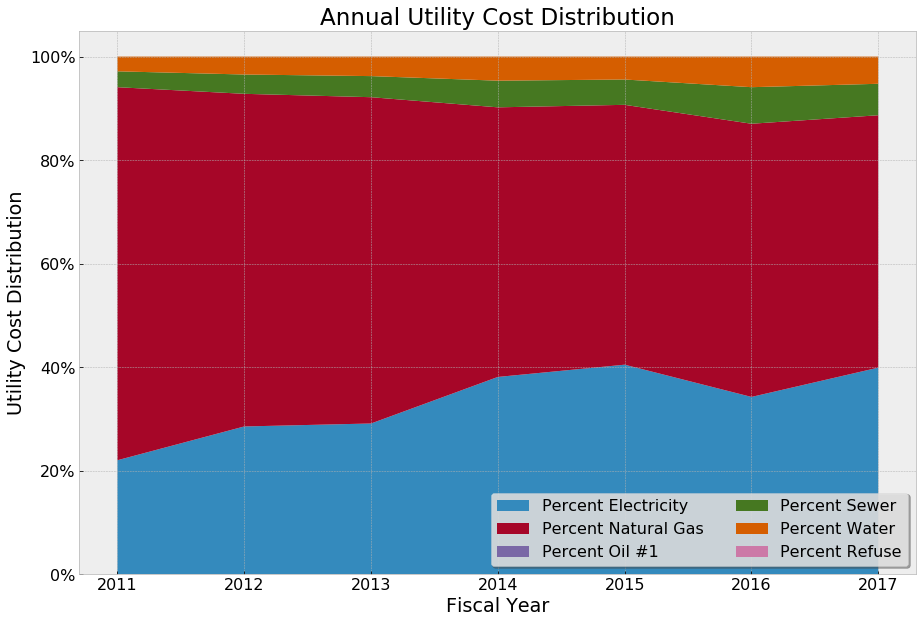

In [42]:
# Reset the index so the fiscal year column can be passed to the graphing utility
reset_df2 = df2.reset_index()

file_name = site + "_graph_pg3_g2.png"

utility_list = ['Electricity', 'Natural Gas', 'Oil #1', 'Sewer', 'Water', 'Refuse']

gu.area_cost_distribution(reset_df2, 'fiscal_year', utility_list, file_name)

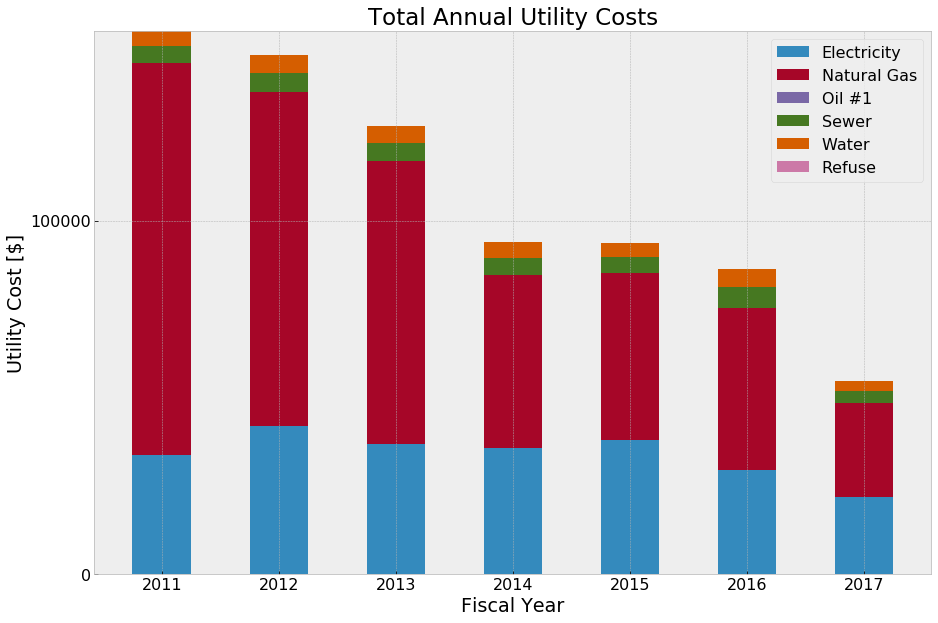

In [43]:
file_name2 = site + "_graph_pg3_g1.png"

gu.create_stacked_bar(reset_df2, 'fiscal_year', utility_list, file_name2)

## Export Data to Dictionary

In [44]:
# Export the rows of the DataFrame into a list of dictionaries for use
# in the template.  Rename columns to match template variables.
row_dicts = bu.df_to_dictionaries(df2, change_names={'Natural Gas': 'natural_gas', 'Oil #1': 'fuel_oil'})
row_dicts

[{'Electricity': 21849.234848484841,
  'Refuse': 0.0,
  'Sewer': 3326.4400000000001,
  'Steam': 0.0,
  'Total': 54733.42531723484,
  'Water': 2875.3299999999995,
  'fiscal_year': 2017,
  'fuel_oil': 0.0,
  'hdd': 12356.0,
  'month_count': 9.0,
  'natural_gas': 26682.420468749999,
  'pct_change': -0.36730390947936598},
 {'Electricity': 29639.448484848483,
  'Refuse': 0.0,
  'Sewer': 6108.2274999999991,
  'Steam': 0.0,
  'Total': 86508.240112872678,
  'Water': 5113.3625000000011,
  'fiscal_year': 2016,
  'fuel_oil': 0.0,
  'hdd': 12171.0,
  'month_count': 12.0,
  'natural_gas': 45647.201628024202,
  'pct_change': -0.078680779696023495},
 {'Electricity': 38017.419166666674,
  'Refuse': 0.0,
  'Sewer': 4593.0161666666672,
  'Steam': 0.0,
  'Total': 93896.054924731172,
  'Water': 4156.9423333333343,
  'fiscal_year': 2015,
  'fuel_oil': 0.0,
  'hdd': 12393.0,
  'month_count': 12.0,
  'natural_gas': 47128.677258064497,
  'pct_change': -0.0013910368310102728},
 {'Electricity': 35843.8221551724

In [45]:
# Put results into the final report dictionary that will be passed to the Template.
# This assumes you have created a couple graphs with the file names shown below.
pg3 = dict(rows=row_dicts, 
           g1='output/images/{}_pg2_g1.png'.format(site), 
           g2='output/images/{}_pg2_g2.png'.format(site)
      )
pg3

{'g1': 'output/images/ANSBG1_pg2_g1.png',
 'g2': 'output/images/ANSBG1_pg2_g2.png',
 'rows': [{'Electricity': 21849.234848484841,
   'Refuse': 0.0,
   'Sewer': 3326.4400000000001,
   'Steam': 0.0,
   'Total': 54733.42531723484,
   'Water': 2875.3299999999995,
   'fiscal_year': 2017,
   'fuel_oil': 0.0,
   'hdd': 12356.0,
   'month_count': 9.0,
   'natural_gas': 26682.420468749999,
   'pct_change': -0.36730390947936598},
  {'Electricity': 29639.448484848483,
   'Refuse': 0.0,
   'Sewer': 6108.2274999999991,
   'Steam': 0.0,
   'Total': 86508.240112872678,
   'Water': 5113.3625000000011,
   'fiscal_year': 2016,
   'fuel_oil': 0.0,
   'hdd': 12171.0,
   'month_count': 12.0,
   'natural_gas': 45647.201628024202,
   'pct_change': -0.078680779696023495},
  {'Electricity': 38017.419166666674,
   'Refuse': 0.0,
   'Sewer': 4593.0161666666672,
   'Steam': 0.0,
   'Total': 93896.054924731172,
   'Water': 4156.9423333333343,
   'fiscal_year': 2015,
   'fuel_oil': 0.0,
   'hdd': 12393.0,
   'month

## Convert the Notebook into a Script

In [46]:
# Convert the notebook to a script.
#!jupyter nbconvert --to script alan_report_pages.ipynb